## Threshold irradiance vs. pulse width and distance

Here we will replicate figure 3 of Foutz et al., 2012 for different model combos:

| Original | Replicated|
| - | - |
| ![Foutz et al., 2012 Figure 3](img/orig/foutz12_3.jpg) | ![Replication of Foutz et al., 2012 Figure 3](img/repl/foutz12_3.svg)|

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"

In [2]:
from cleosim import CLSimulator
from cleosim.opto import *
from cleosim.coordinates import assign_coords_grid_rect_prism
from brian2 import SpikeMonitor, Network, prefs
prefs.codegen.target = 'cython'

def get_Irr0_thres(pulse_widths, distance_mm, ng, precision=1, simple_opto=False):
    mon = SpikeMonitor(ng, record=False)

    assign_coords_grid_rect_prism(
        ng,
        xlim=(0, 0),
        ylim=(0, 0),
        zlim=(distance_mm, distance_mm),
        unit=mm,
        shape=(1, 1, 1),
    )

    net = Network(mon, ng)
    sim = CLSimulator(net)

    if simple_opto:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=ProportionalCurrentModel(
                # use 240*(thresh-E_L) factor from tutorial
                Iopto_per_mW_per_mm2=15 * (20 * mV) / (500 * Mohm)
            ),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    else:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=FourStateModel(ChR2_four_state),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    sim.inject_stimulator(opto, ng)

    sim.network.store()
    Irr0_thres = []
    for pw in pulse_widths:
        search_min, search_max = (0, 10000)
        while (
            search_max - search_min > precision
        ):  # get down to {precision} mW/mm2 margin
            sim.network.restore()
            Irr0_curr = (search_min + search_max) / 2
            opto.update(Irr0_curr)
            sim.run(pw * ms)
            opto.update(0)
            sim.run(10 * ms)  # wait 10 ms to make sure only 1 spike
            if mon.count > 0:  # spiked
                search_max = Irr0_curr
            else:
                search_min = Irr0_curr
        Irr0_thres.append(Irr0_curr)

    return Irr0_thres


We prepare a pandas dataframe in tidy format:

In [3]:
import pandas as pd
df = pd.DataFrame(columns=["name", "distance", "pulse_width", "threshold"])
df

,name,distance,pulse_width,threshold


We need to get the original data for comparison:

In [4]:
wpd_data = pd.read_csv('data/foutz12_3_wpd.csv')
wpd_data.head()

,1.5 mm,Unnamed: 1,1 mm,Unnamed: 3,0.5 mm,Unnamed: 5
0,X,Y,X,Y,X,Y
1,2.8036529680365296,2004.8387096774195,1.4155251141552503,2000,0.6392694063926934,2000
2,2.9132420091324196,1830.6451612903227,1.5981735159817338,1554.8387096774195,0.6849315068493147,1666.1290322580646
3,3.1050228310502277,1661.2903225806454,1.9726027397260264,1061.2903225806451,0.7853881278538806,1322.5806451612905
4,3.4063926940639266,1438.7096774193549,2.5114155251141543,679.0322580645161,0.8812785388127846,1032.258064516129


In [5]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data)):
        if pd.isna(wpd_data.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "Foutz et al., 2012",
            wpd_data.columns[i_col],
            wpd_data.iloc[i_row, i_col],
            wpd_data.iloc[i_row, i_col + 1],
        ]
df.pulse_width = df.pulse_width.astype(float)
df.threshold = df.threshold.astype(float)


In [6]:
df.tail()

,name,distance,pulse_width,threshold
41,"Foutz et al., 2012",0.5 mm,4.365297,54.838710
42,"Foutz et al., 2012",0.5 mm,5.132420,40.322581
43,"Foutz et al., 2012",0.5 mm,5.707763,35.483871
44,"Foutz et al., 2012",0.5 mm,6.730594,11.290323
45,"Foutz et al., 2012",0.5 mm,9.990868,6.451613


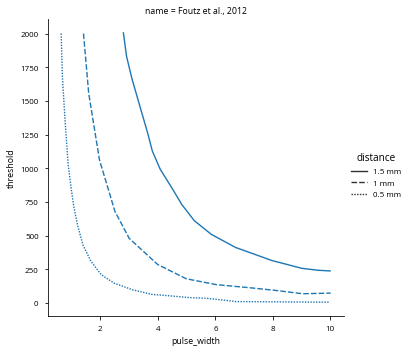

In [7]:
def plot_thresh(data):
    sns.relplot(
        data=data,
        kind="line",
        col='name',
        x="pulse_width",
        y="threshold",
        units="distance",
        style="distance",
        estimator=None,
    )

plot_thresh(df)

Looks right. Time to test the models.

In [8]:
from opto_val import lif, adex

data_already_generated = False
if not data_already_generated:
    pulse_widths = np.arange(0.2, 10.2, 0.2)
    for ng_constructor in [lif, adex]:
        for simple_opto in [True, False]:
            for dist in [1.5, 1, 0.5]:
                ng = ng_constructor(1)
                Irr0_thres = get_Irr0_thres(pulse_widths, dist, ng, simple_opto=simple_opto)
                opsin_name = "Simple" if simple_opto else "Markov"
                name = f"{ng.name} + {opsin_name} opsin"
                df = pd.concat(
                    [
                        df,
                        pd.DataFrame(
                            {
                                "name": name,
                                "distance": f"{dist} mm",
                                "pulse_width": pulse_widths,
                                "threshold": Irr0_thres,
                            }
                        ),
                    ]
                )
    df = df.reset_index(drop=True)
    df.to_csv("data/thresholds.csv", index=False)
    data_already_generated = True
    df.tail()

INFO       No numerical integration method specified for group 'LIF', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'AdEx', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


We load the saved data here to skip the long simulation in the future.

And we tweak the model names to optimize for visualization:

In [33]:
df = pd.read_csv('data/thresholds.csv')
df.name = df.name.replace(regex=r'Foutz et al., 2012', value='Morphological HH neuron + Markov opsin')
df.name = df.name.replace(regex=r' \+ ', value='\n')
df.name = df.name.replace(regex=r'LIF', value='LIF neuron')
df.name = df.name.replace(regex=r'AdEx', value='AdEx neuron')
df.name = df.name.replace(regex=r'simple', value='Simple')
df

,name,distance,pulse_width,threshold
0,Morphological HH neuron\nMarkov opsin,1.5 mm,2.803653,2004.838710
1,Morphological HH neuron\nMarkov opsin,1.5 mm,2.913242,1830.645161
2,Morphological HH neuron\nMarkov opsin,1.5 mm,3.105023,1661.290323
3,Morphological HH neuron\nMarkov opsin,1.5 mm,3.406393,1438.709677
4,Morphological HH neuron\nMarkov opsin,1.5 mm,3.643836,1264.516129
...,...,...,...,...
641,AdEx neuron\nMarkov opsin,0.5 mm,9.200000,1.831055
642,AdEx neuron\nMarkov opsin,0.5 mm,9.400000,1.831055
643,AdEx neuron\nMarkov opsin,0.5 mm,9.600000,1.831055
644,AdEx neuron\nMarkov opsin,0.5 mm,9.800000,1.831055


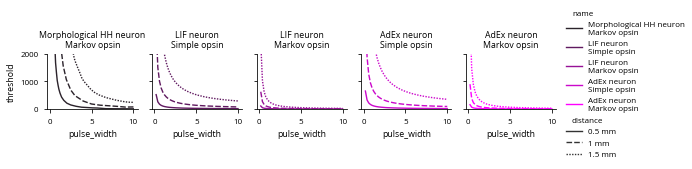

In [51]:
plot_thresh(df, 'dark:fuchsia')

## Main figure
With original, LIF+simple, and AdEx+Markov

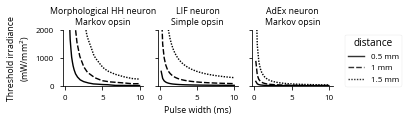

In [41]:
def plot_thresh(data, palette):
    g = sns.relplot(
        data=data,
        kind="line",
        col="name",
        x="pulse_width",
        y="threshold",
        style="distance",
        style_order=["0.5 mm", "1 mm", "1.5 mm"],
        hue="name",
        estimator=None,
        height=1.8,
        aspect=0.9,
        palette=palette,
    )
    g.set(ylim=(0, 2000))
    g.set_titles(col_template="{col_name}")
    return g


g = plot_thresh(
    df[~df.name.str.contains("LIF neuron\nMarkov opsin|AdEx neuron\nSimple opsin", regex=True)],
    palette=["k", "k", "k"],
)
g.set_axis_labels("", "Threshold irradiance\n(mW/mm$^2$)")
g.axes[0, 1].set_xlabel("Pulse width (ms)")
g.legend.remove()
g.fig.legend(
    handles=g.legend.legendHandles[-3:],
    bbox_to_anchor=(0.88, 0.5),
    loc="center right",
    title="distance",
)
g.fig.savefig('img/fig/opto_thresh_main.svg')

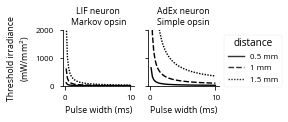

In [46]:
g = plot_thresh(df[df.name.str.contains('LIF neuron\nMarkov opsin|AdEx neuron\nSimple opsin', regex=True)], palette=['k', 'k'])
g.set_axis_labels("Pulse width (ms)", "Threshold irradiance\n(mW/mm$^2$)")
# g.axes[0, 1].set_xlabel("Pulse width (ms)")
g.legend.remove()
g.fig.legend(handles=g.legend.legendHandles[-3:], bbox_to_anchor=(.95, 0.5), loc='center right', title='distance')
g.fig.savefig('img/fig/opto_thresh_supp.svg')